In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
# Load local modules
import sys
sys.path.append('d:\\Users\\serfe\\Documents\\GitHub\\seisinv\\src')
from basic_ops_seis_inv import Filtering, ConversionTool, MathOps, Error

c:\Users\serfe\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


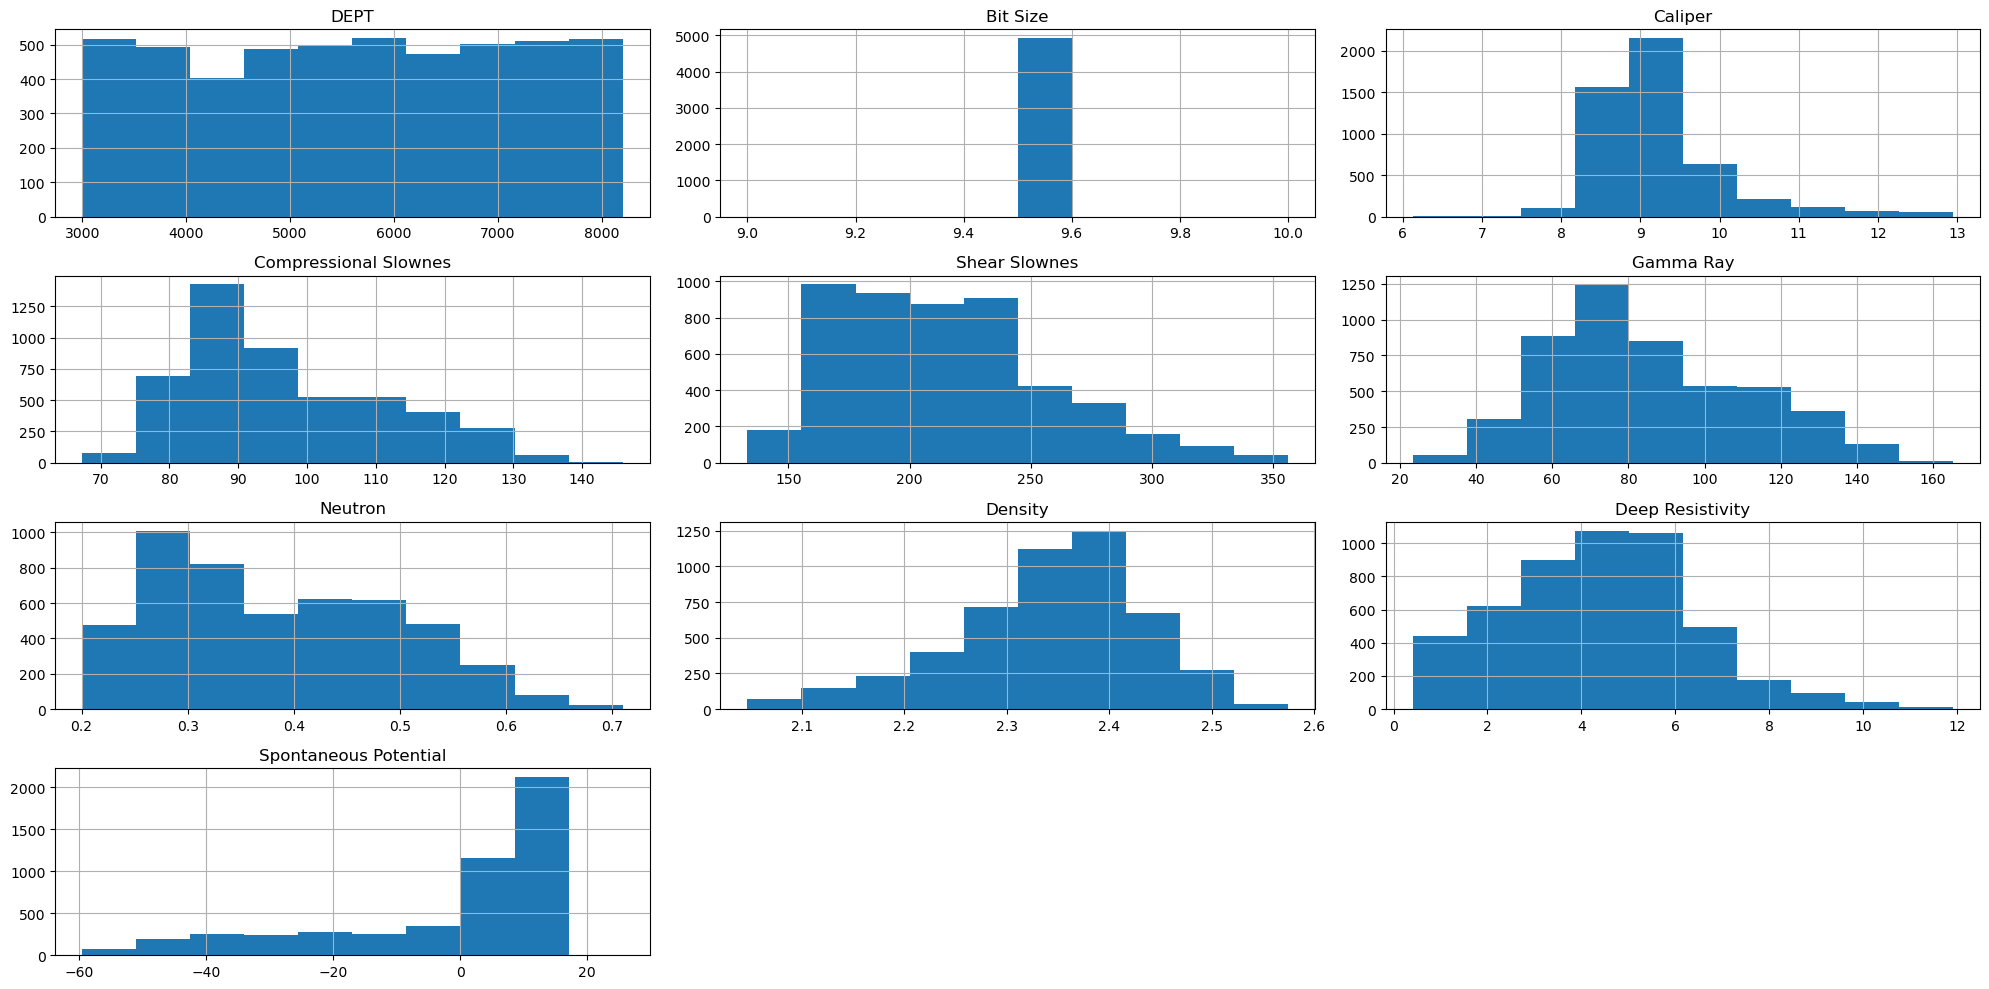

In [2]:
# Load data
path_data = 'd:\\Users\\serfe\\Documents\\GitHub\\seisinv\\data\\Task2_data.xlsx'
df = pd.read_excel(path_data)
# Remove outliers
df = Filtering().remove_outliers(df, drop_col=['Surface', 'Bit Size'])
# Plot data
df.hist(figsize=(20,10))
plt.tight_layout()

In [3]:
# Backus conversion to seismic domain
vp = 1 / ConversionTool().SI_conversion(df['Compressional Slownes'], 'micros/ft')
vs = 1 / ConversionTool().SI_conversion(df['Shear Slownes'], 'micros/ft')
rho = ConversionTool().SI_conversion(df['Density'], 'g/cm3')
depth = df['DEPT']
vp0, vs0, rho0, dept0 = ConversionTool(104, vp, vs, rho, 3000, depth).backus_downsampling()

Output units: kg/m3
Original sampling frequency (in well-log domain) is: 14853.21312132847 Hz
New sampling frequency (in seismic domain) is: 119.49768920340398 Hz


Text(0.5, 1.0, 'Backus conversion: From Well-log domain to Seismic domain')

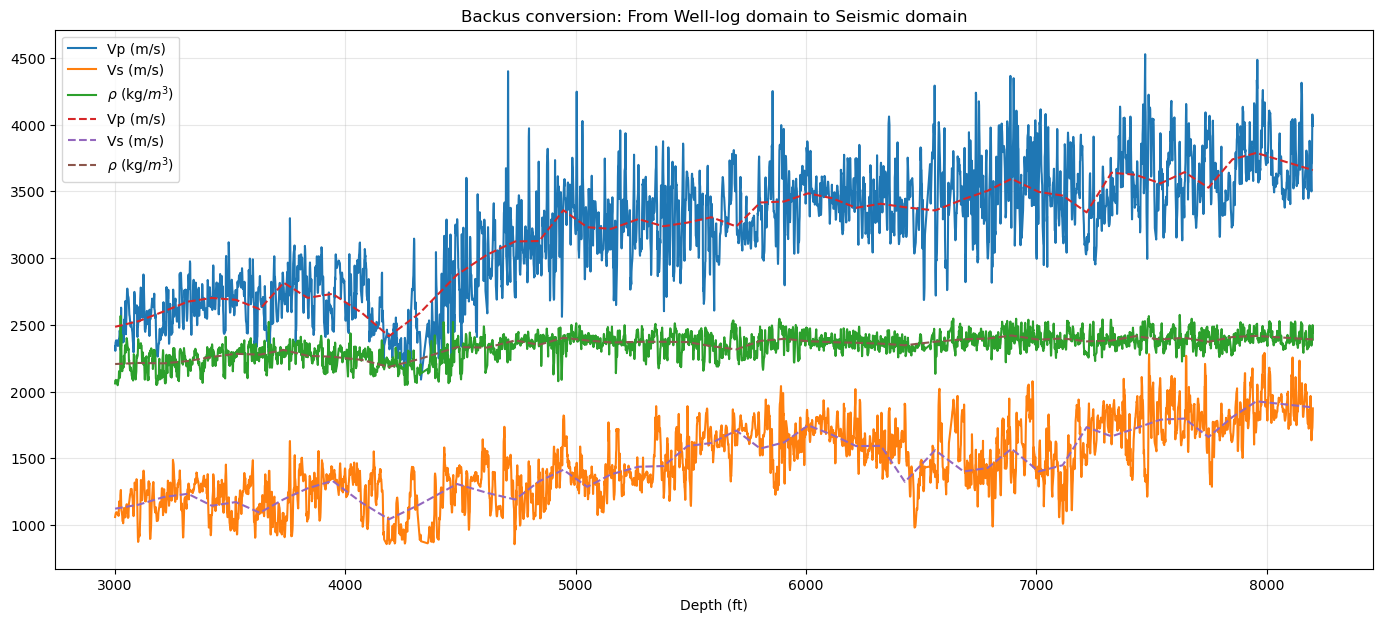

In [4]:
# Plot resmapled data
fig = plt.figure(figsize=(17,7))
plt.plot(df.DEPT, vp, label='Vp (m/s)')
plt.plot(df.DEPT, vs, label='Vs (m/s)')
plt.plot(df.DEPT, rho, label=fr'$\rho$ (kg/$m^3$)')
plt.plot(dept0, vp0, label='Vp (m/s)', linestyle='dashed')
plt.plot(dept0, vs0, label='Vs (m/s)', linestyle='dashed')
plt.plot(dept0, rho0, label=fr'$\rho$ (kg/$m^3$)', linestyle='dashed')
plt.xlabel('Depth (ft)')
plt.grid(alpha=.3)
plt.legend(ncol=1)
plt.title('Backus conversion: From Well-log domain to Seismic domain')

# Seismic Genetic Inversion

Text(0, 0.5, 'Depth (ft)')

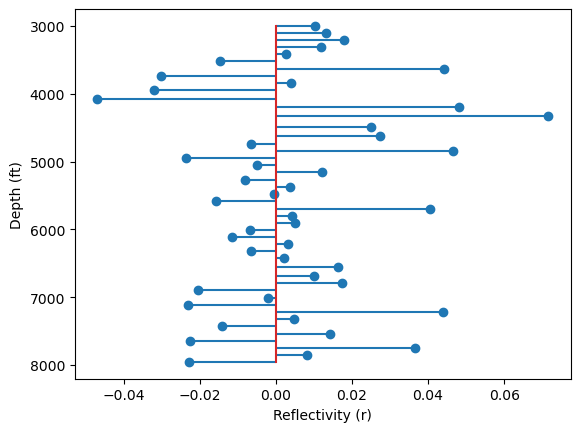

In [5]:
# Calculate the original reflectivity profile (obtained from well-log to seismic domain)
math_ops = MathOps(vp=vp0, rho=rho0)
Z = math_ops.calc_impedance()
r = math_ops.calc_r(Z_data=Z)
plt.stem(dept0[:-1], r, orientation='horizontal')
plt.gca().invert_yaxis()
plt.xlabel('Reflectivity (r)')
plt.ylabel('Depth (ft)')

In [6]:
print(f'There are {len(vp0)} samples in the new seismic domain.')

There are 47 samples in the new seismic domain.


We will create 10000 random models with some constrains for $v_p$, $v_s$ and $\rho$. As there are 47 samples, we will create 47 gens, that will form a chromosome. The folllowing is na example of 1 chromosome formed by 47 gens.

In [7]:
M_shape = (47, 10000)
# Initialize the random values for Vp, Vs a,d rho that are going to form the chromosome.
rho_gen = np.random.uniform(1.5, 2.8, M_shape)*1000
vs_gen = np.random.uniform(1.0, 1.9, M_shape)*1000
vp_gen = np.random.uniform(1.9, 6, M_shape)*1000

In [19]:
# One chromosome from 10000 possible chromosomes
# Each cell/row is a gen
n_chromosome = 0
rho_chromosome = rho_gen[:,n_chromosome]
vp_chromosome = vp_gen[:,n_chromosome]
vs_chromosome = vs_gen[:,n_chromosome]
chromosome = np.stack([rho_chromosome, vp_chromosome, vs_chromosome], axis=1)
print(fr'The columns are: $\rho$, $v_p$, $v_s$')
print('Example of 1 chromoosme with 47 gens', '\n')
print(chromosome)
# Now let's calculate the reflectivity profile for the chromosome
math_ops = MathOps(vp=vp_chromosome, rho=rho_chromosome)
Z_chromosome = math_ops.calc_impedance()
r_chromosome = math_ops.calc_r(Z_data=Z_chromosome)
# Now compare the real reflectivity profile with the generic one.
error = Error(y_true=r, y_pred=r_chromosome)
l1_error, l2_error = error.l1_error(), error.l2_error()
print('Errors between original and chromosome reflectivity profiles.', '\n')
print(f'l1 error: {l1_error}%')
print(f'l2 error: {l2_error}%')


The columns are: $\rho$, $v_p$, $v_s$
Example of 1 chromoosme with 47 gens 

[[2778.03222809 3308.13500753 1526.88369249]
 [2413.18312836 2877.67776288 1388.41376245]
 [2065.89898347 4615.32722546 1486.58512782]
 [1506.53386965 3639.24777639 1810.27289432]
 [2233.10024971 3787.40253611 1773.19257999]
 [1841.74202328 2971.22716462 1374.21350572]
 [1612.37993363 4323.15105902 1582.28473861]
 [1578.87233443 3166.6828431  1159.46909589]
 [2684.68490337 5770.61927927 1749.06426889]
 [1996.51181401 2637.86682231 1896.76186894]
 [1820.50110046 3168.45421601 1874.33209595]
 [2409.29813257 4525.46171545 1325.40044158]
 [2156.39656654 2537.29688036 1210.39758129]
 [1819.3781217  5717.07137633 1688.63423689]
 [1611.97187012 5717.87451562 1848.71286319]
 [1724.5672932  4608.80019421 1514.04763615]
 [2055.86466205 2842.92737457 1328.1502691 ]
 [2301.82497941 5163.86851697 1777.38299931]
 [1901.17334534 3644.38126283 1304.14850504]
 [1896.79512739 2374.70366933 1182.27420085]
 [2147.17387525 5569.43

Now that we have seen an example in which we built a chromosome, then calculated its reflectivity profile and finally compared results with the original one to evaluate what the similarity/error between the two reflectivity profiles is. Now, let's apply the same steps to multiple chromosomes and keep only those whose error is smaller than 5%.